# 필요한 라이브러리 호출

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

# 원본 이미지 오픈

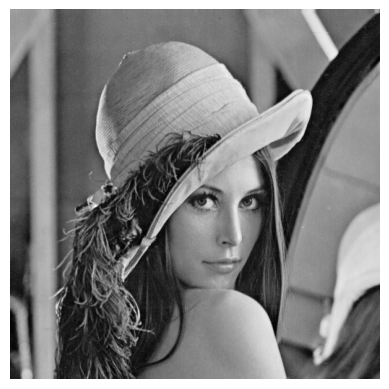

In [2]:
# 이미지 열기
img = Image.open("lena.png")
# numpy 배열로 변환
lena = np.array(img)
plt.imshow (lena, cmap="gray")
plt.axis('off')
plt.show()

# DCT transformation

In [22]:
bit = []
for i in range(5000):
    np.random.seed(i)
    bit.append(np.random.choice([-1,1],size = 32))
bit = np.array(bit)
bit.shape

(5000, 32)

In [6]:
bit = [1,0,0,1,0,1,0,0,1,1,1,0,1,0,0,0,1,0,1,0,1,1,1,1,0,1,0,1,1,0,1,0]
lst = []
for i in bit:
    if i ==1 :
        lst.append(1)
    else:
        lst.append(-1)
Bipolar_bit = lst
Bipolar_bit


IndentationError: unexpected indent (2564541056.py, line 10)

In [4]:
from scipy.fftpack import dct
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
dct_coefficient_map = dct2(lena)
dct_coefficient_map


array([[ 6.35138359e+04, -5.21554505e+03, -1.21677678e+03, ...,
         9.13871276e-02, -6.70376488e+00, -1.36926906e+01],
       [ 3.54985931e+03,  3.89898521e+03, -3.24788864e+03, ...,
         5.87695132e+00,  9.24036731e+00,  1.45845311e+01],
       [-1.04167654e+02,  1.55880942e+03, -2.99185389e+03, ...,
        -5.76847727e-01, -7.69732109e+00, -1.07811232e+00],
       ...,
       [ 5.09879858e-01, -3.08790330e+00, -2.82732607e+00, ...,
        -8.19767535e-01,  3.19798866e+00,  1.78178103e+00],
       [ 3.68654477e+00, -2.08645801e+00,  3.69259430e+00, ...,
        -1.54677520e+00, -3.56430138e-01,  3.62120502e+00],
       [-1.44365810e+00,  1.16751817e+00, -2.12558585e+00, ...,
         2.25530558e+00,  3.38327916e+00, -2.29017487e-01]],
      shape=(512, 512))

# Zigzag 알고리즘으로 중주파수 인덱스 찾아서 저장

In [5]:
def zigzag_choice():
    low2mid_frequency_index = [] # 16000 ~ 32000 사이의 총 16000개를 담을거임
    x,y = 0,0
    count = 0
    diagonal_count = 0
    while(1):
        diagonal_count = diagonal_count + 1
        y = y + 1

        low2mid_frequency_index.append((x,y))
        count = count + 1
        if count == 32000 :break
         # 대각선으로 내려가는 지그재그
        for i in range(diagonal_count):
            x = x + 1
            y = y-1
            low2mid_frequency_index.append((x,y))
            count = count + 1
            if count == 32000 : break
        if count == 32000 : break
        x = x+1
        diagonal_count = diagonal_count + 1

        low2mid_frequency_index.append((x,y))
        count = count + 1
        if count == 32000 : break
        for i in range(diagonal_count):
            x = x-1
            y = y+1
            low2mid_frequency_index.append((x,y))
            count = count + 1
            if count == 32000 : break
        if count == 32000 : break
    return low2mid_frequency_index[16000:]
len(zigzag_choice())


16000

# 워터마킹 삽입

In [6]:
import numpy as np

a = np.arange(30).reshape(3, 10)
a[0,:] *= -1
print(a)


[[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]]


In [7]:
def watermarking_casting(dct_coefficient_map):
    mid_frequency_index = zigzag_choice()
    P_sequence = []
    # 각 비트별 16000개의 시퀀스 생성 . shpae: 32,16000 (랜덤 +1,-1 이 생성됨)
    for i in range(32):
        np.random.seed(i)
        P_sequence.append(np.random.choice([-1, 1], size=16000))
    P_sequence = np.array(P_sequence) # shape: 32,16000

    # 비트(+1,-1)랑 각 시퀀스의 곱으로 삽입할 워터마크 생성
    for i in range(32):
        P_sequence[i, :] = P_sequence[i, :] * Bipolar_bit[i]
    # 각 시퀀스의 합으로 삽입할 워터마크 생성
    watermark = np.sum(P_sequence, axis=0)

    watermark_index_count = 0
    alpha = 0.09
    for i,j in mid_frequency_index:
        dct_coefficient_map[i][j] = dct_coefficient_map[i][j] + \
                                    alpha*abs(dct_coefficient_map[i][j])*watermark[watermark_index_count]
        watermark_index_count = watermark_index_count + 1
    return dct_coefficient_map
watermarking_DCT = watermarking_casting(dct_coefficient_map)

# IDCT로 워터마킹 삽입된 이미지로 변환


In [8]:
from scipy.fftpack import idct

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

watermarking_image = idct2(watermarking_DCT)
Image.fromarray(watermarking_image).show()

In [9]:
import numpy as np
import cv2

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:  # 두 이미지가 완전히 동일한 경우
        return float('inf')
    max_pixel = 255.0  # 8비트 이미지일 경우
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# 예시: watermarking_image, lena 가 numpy array 형태라고 가정
# 만약 cv2.imread 등으로 읽으면 BGR numpy array가 됩니다.
# watermarking_image = cv2.imread("watermarked.png", cv2.IMREAD_COLOR)
# lena = cv2.imread("lena.png", cv2.IMREAD_COLOR)

psnr_value = psnr(watermarking_image, lena)
print("PSNR :", psnr_value, "dB")


PSNR : 38.83395987821689 dB


# 워터마킹 탐지


In [10]:
def watermarking_detection(img):
    # 이미지를 DCT변환
    dct_img = dct2(img)

    # 중주파수 떼옴
    mid_frequency_index = zigzag_choice()
    real_watermarking_sequence = []
    for i,j in mid_frequency_index:
        real_watermarking_sequence.append(dct_img[i][j])
    real_watermarking_sequence = np.array(real_watermarking_sequence)

    # 시드 알고있으니 다시 생성
    P_sequence = [] # 삽입한 시드로 P시퀀스 다시 생성
    for i in range(32):
        np.random.seed(i)
        P_sequence.append(np.random.choice([-1, 1], size=16000))
    P_sequence = np.array(P_sequence)

    # correlation 계산
    detection_bit = np.matmul(P_sequence, real_watermarking_sequence)/16000
    return detection_bit

detection_bit = watermarking_detection(watermarking_image)
detection_bit


array([ 1.70681559, -1.53221524, -1.7016812 ,  1.24398642, -1.58546474,
        1.21645552, -1.79454869, -1.2788703 ,  1.9307922 ,  1.65964165,
        1.7722075 , -1.42176949,  1.47612704, -1.78694868, -1.38594919,
       -1.56373011,  1.70837597, -1.41389826,  1.52021227, -1.58221813,
        1.59897507,  1.63154101,  1.86372479,  1.52896549, -1.57531168,
        1.5322085 , -1.77777361,  1.76005038,  1.56227733, -1.65684884,
        1.70465136, -1.63761149])

In [15]:
lst = []
for i in range(32):
    if detection_bit[i] >0:
        lst.append(1)
    else:
        lst.append(0)
print(lst,end=" ")
print()
print(bit,end=" ")


[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0] 
[1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0] 

In [14]:
error_count = 0
for i in range(32):
    if ss[i] != bit[i]:
        error_count = error_count + 1
print("BER : %f" % (error_count / 32))

BER : 0.000000
